In [244]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random

from aequitas.group import Group
from aequitas.bias import Bias
import aequitas.plot as ap

#import seaborn as sns
import matplotlib.pyplot as plt
#from aequitas.fairness import Fairness
#sns.set()
#DPI = 200

warnings.filterwarnings("ignore")

In [217]:
# Let's use the methods 
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
            TruePositiveRateDifference
from fairlearn.metrics import selection_rate_group_summary

### FUNCTIONS

In [280]:
def binary(df, df_index):
    decileScores = []
    for x in range(0, len(df["DecileScore"])):
        if df["DecileScore"][3*x+df_index] >= 1 and df["DecileScore"][3*x+df_index] <= 5:
            decileScores.append("Low")
        elif df["DecileScore"][3*x+df_index] >= 6 and df["DecileScore"][3*x+df_index] <= 10:
            decileScores.append("High")
        else:
            decileScores.append("NA")
    df["binaryScore"] = decileScores

def findSlash(sdate):
    slashes = []
    for x in range(0, len(sdate)):
        if sdate[x] == "/" or sdate[x] == " ":
            slashes.append(x)
    return slashes

def age(dob, sdate):
    #True = 1, False = 0
    byear = int(dob[6:])
    bmonth = int(dob[3:5])
    bday = int(dob[:2])
    
    slashes = findSlash(sdate)
    syear = int(sdate[slashes[1]+1:slashes[2]])
    smonth = int(sdate[slashes[0]+1:slashes[1]])
    sday = int(sdate[:slashes[0]])
    
    year_4_digits = syear - byear - ((smonth, sday) < (bmonth, bday))
    return year_4_digits % 100

def sigsum(a):
    sigs = []
    for i in range(0, len(a)):
        sigmoid = 1 / (1 + math.exp(-a[i]))
        sigs.append(sigmoid)
    return np.array(sigs)

def preprocess(df, df_index):
    df = df.drop(["Person_ID", "AssessmentID", "Case_ID", "LastName", "FirstName", "MiddleName", "AssessmentReason", "Scale_ID", "DisplayText", "IsCompleted", "IsDeleted"], axis=1)
    df = df.drop(["ScaleSet", "ScaleSet_ID", "AssessmentType"], axis=1)
    df = df.drop("RecSupervisionLevel", axis=1)
    binary(df, df_index)
    #have to calculate ages before dropping na scoreText values bc it causes missing indices
    ages = []
    for x in range(0, len(df["DateOfBirth"])):
        ages.append(age(df["DateOfBirth"][3*x+df_index], df["Screening_Date"][3*x+df_index]))
    df["Age"] = ages
    df = df.drop(["DateOfBirth", "Screening_Date"], axis=1)
    df = df.drop(df[pd.isna(df["ScoreText"])].index, axis=0)
    df = df.drop(["RawScore", "DecileScore", "ScoreText"], axis=1)
    for x in range (0, 9):
        df[df.columns[x]] = pd.factorize(df[df.columns[x]])[0]
        
    return df
    
def pred_model(clf, feat_index, df, save_score=False):
    features = df.iloc[:, feat_index]
    predictions = clf.predict(features)
    actuals = df["binaryScore"].values
    #probs = clf.predict_proba(features)
    
    if save_score:
        df['score'] = predictions
        #df['predict_proba'] = np.amax(probs, axis=1)
    
    print(classification_report(actuals, predictions))
    score = clf.score(features, actuals)
    print("\n Accuracy Score: {0}".format(score))
    
    return df
    
    
def train_val_model(train, val, feat_index, model):
    features = train.iloc[:,feat_index]
    risk = train["binaryScore"].values
    
    model.random_state = random.randrange(1, 1000)
    clf = model.fit(features, risk)
    pred_model(clf, feat_index, val)
    
    return clf


def aequitas_audit(input_df, ref_groups_dict):
    g = Group()
    b = Bias()
    xtab, _ = g.get_crosstabs(input_df[['score','label_value'] + list(ref_groups_dict.keys())].copy())
    bdf = b.get_disparity_predefined_groups(xtab, input_df, ref_groups_dict)
    return bdf

In [281]:
#Load the dataset
df_full=pd.read_csv("compas-scores-raw.csv")
df_violence = df_full.loc[df_full["DisplayText"] == "Risk of Violence"]
df_recidivism = df_full.loc[df_full["DisplayText"] == "Risk of Recidivism"]
df_failure = df_full.loc[df_full["DisplayText"] == "Risk of Failure to Appear"]

#preprocess the data
df_violence = preprocess(df_violence, 0)
df_recidivsm = preprocess(df_recidivism, 1)
df_failure = preprocess(df_failure, 2)


## Prediction of Recidivism

In [400]:
#Train the models for RF and LR

train, test = train_test_split(df_recidivsm, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
feat_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
feat_index.remove(8)
    
#RF
print("\n***** RANDOM FOREST MODEL ******\n")
model = RandomForestClassifier(random_state = 333, n_estimators = 50, max_features=5, \
                                 min_samples_split=100, min_samples_leaf = 50)
clf_violence_RF = train_val_model(train, val, feat_index, model)

#LR
print("\n ***** LOGISTIC REGRESSION MODEL ******\n")
model = LogisticRegression(random_state=12, max_iter=1000)
clf_violence_LR = train_val_model(train, val, feat_index, model)


***** RANDOM FOREST MODEL ******

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2729
           1       0.94      0.99      0.96      1320

    accuracy                           0.98      4049
   macro avg       0.97      0.98      0.97      4049
weighted avg       0.98      0.98      0.98      4049


 Accuracy Score: 0.9760434675228451

 ***** LOGISTIC REGRESSION MODEL ******

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2729
           1       0.91      0.91      0.91      1320

    accuracy                           0.94      4049
   macro avg       0.93      0.93      0.93      4049
weighted avg       0.94      0.94      0.94      4049


 Accuracy Score: 0.9414670288960237


In [401]:
#Test set prediction

#RF
print("\n***** RANDOM FOREST MODEL ******\n")
pred_model(clf_violence_RF, feat_index, test, save_score=True)


#LR
print("\n ***** LOGISTIC REGRESSION MODEL ******\n")
pred_model(clf_violence_LR, feat_index, test, save_score=False)



***** RANDOM FOREST MODEL ******

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2669
           1       0.93      0.99      0.96      1380

    accuracy                           0.97      4049
   macro avg       0.96      0.98      0.97      4049
weighted avg       0.97      0.97      0.97      4049


 Accuracy Score: 0.9723388490985428

 ***** LOGISTIC REGRESSION MODEL ******

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2669
           1       0.90      0.90      0.90      1380

    accuracy                           0.93      4049
   macro avg       0.93      0.92      0.92      4049
weighted avg       0.93      0.93      0.93      4049


 Accuracy Score: 0.9325759446776982


,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevelText,binaryScore,Age,score
32041,0,0,1,0,0,0,0,0,0,35,0
25168,0,0,1,0,0,0,1,0,0,50,0
2473,2,0,1,0,0,2,0,0,0,24,0
50902,0,0,2,0,3,1,3,0,0,34,0
1651,0,0,1,0,0,2,0,2,1,30,1
...,...,...,...,...,...,...,...,...,...,...,...
30469,0,0,0,0,0,0,0,2,0,19,1
29656,1,0,1,0,1,1,0,2,1,18,1
8494,0,0,2,0,0,0,0,0,0,28,0
26920,1,0,2,0,1,1,0,0,0,24,0


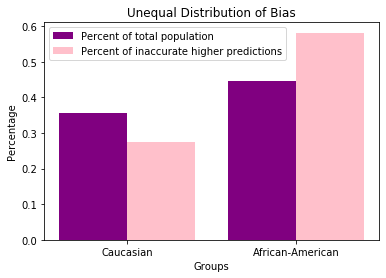

In [402]:
X = test.copy()
test_predictions = test.score.values
test_actuals = test["binaryScore"].values

X["prediction"] = test_predictions
X["actual"] = test_actuals
X["bias"] = X["actual"] < X["prediction"]

worseTotal = X.loc[X["bias"]]
def biasRatio(ethnic_code):
    worsePerRace = len(worseTotal.loc[worseTotal["Ethnic_Code_Text"] == ethnic_code])
    totalPerRace = len(X.loc[X["Ethnic_Code_Text"] == ethnic_code])
    return [totalPerRace/len(X), worsePerRace/len(worseTotal)]

#caucasian, african-american - statistical significance is a .2 difference generally
X_labels = ['Caucasian','African-American']
totalPercent = [biasRatio(0)[0], biasRatio(1)[0]]
biasPercent = [biasRatio(0)[1], biasRatio(1)[1]]
  
X_axis = np.arange(len(X_labels))
  
plt.bar(X_axis - 0.2, totalPercent, 0.4, color='purple', label = 'Percent of total population') 
plt.bar(X_axis + 0.2, biasPercent, 0.4, color='pink', label = 'Percent of inaccurate higher predictions')
  
plt.xticks(X_axis, X_labels)
plt.xlabel("Groups")
plt.ylabel("Percentage")
plt.title("Unequal Distribution of Bias")
plt.legend()
plt.show()

In [403]:
totalPercent, biasPercent, \
biasPercent[0]/totalPercent[0], \
biasPercent[1]/totalPercent[1]

([0.3551494196097802, 0.44480118547789577],
 [0.2755102040816326, 0.5816326530612245],
 0.7757585649002299,
 1.3076238824235968)

## GOING WITH RANDOM FOREST AS THE MODEL OF CHOICE

In [465]:
label_col='binaryScore'
attr_col = 'Ethnic_Code_Text'
exclude_cols = [label_col]
test_exclude_cols = [label_col, 'score']

# aequitas parameters
metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {attr_col:'1'}

X_train, y_train, A_train = train[[c for c in train.columns if c not in exclude_cols]].values, train[label_col].values, train[[attr_col]]
X_test, y_test, A_test = test[[c for c in test.columns if c not in test_exclude_cols]].values,   test[label_col].values  , test[[attr_col]]


In [466]:
# Step 1. Define the constraint
constraint = DemographicParity()

# Step 2. Define the base estimator (any estimator providing 'fit' and 'predict')
# Note: we could have used other algorithm such as logistic regression or random forest
#base_estimator = LogisticRegression(random_state=3454, max_iter=1000)
base_estimator = RandomForestClassifier(random_state = 3333, n_estimators = 50, max_features=5, \
                                 min_samples_split=100, min_samples_leaf = 50)

# Step 3. Define the bias reducer algorithm you want to apply
bias_reducer = ExponentiatedGradient(base_estimator, constraint, T=25)

# Step 4. Fit the data (and provide the sensitive attributes)
bias_reducer.fit(X_train, y_train, sensitive_features=A_train)

# Step 5. Use the mitigator to make predictions 
y_pred_4 = bias_reducer.predict(X_test)
new_preds_4 = test[test.columns.drop(['score'])].copy()
new_preds_4['score'] = y_pred_4

#Before: de-biasing
old_df = test.copy()
#old_df = old_df.sort_values('predict_proba', ascending=False)
old_df = old_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas
old_df['Ethnic_Code_Text'] = old_df.Ethnic_Code_Text.astype(str) #changing type for Aequitas

In [467]:
bdf_old = aequitas_audit(old_df, protected_attribute_ref_group)
ap.disparity(bdf_old, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

In [468]:
#After: Run Aequitas for the new, fairness-aware model

df_4 = new_preds_4
df_4 = df_4.rename(columns = {label_col:'label_value'}) # naming for Aequitas
df_4['Ethnic_Code_Text'] = df_4.Ethnic_Code_Text.astype(str) #changing type for Aequitas
bdf_4 = aequitas_audit(df_4, protected_attribute_ref_group)
ap.disparity(bdf_4, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

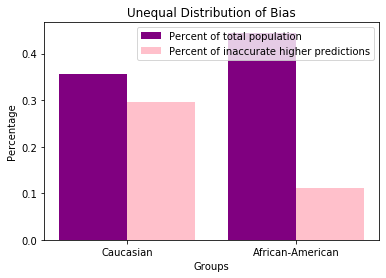

In [469]:
X = new_preds_4
test_predictions = new_preds_4.score.values
test_actuals = new_preds_4["binaryScore"].values

X["prediction"] = test_predictions
X["actual"] = test_actuals
X["bias"] = X["actual"] < X["prediction"]

worseTotal = X.loc[X["bias"]]
def biasRatio(ethnic_code):
    worsePerRace = len(worseTotal.loc[worseTotal["Ethnic_Code_Text"] == ethnic_code])
    totalPerRace = len(X.loc[X["Ethnic_Code_Text"] == ethnic_code])
    return [totalPerRace/len(X), worsePerRace/len(worseTotal)]

#caucasian, african-american - statistical significance is a .2 difference generally
X_labels = ['Caucasian','African-American']
totalPercent = [biasRatio(0)[0], biasRatio(1)[0]]
biasPercent = [biasRatio(0)[1], biasRatio(1)[1]]
  
X_axis = np.arange(len(X_labels))
  
plt.bar(X_axis - 0.2, totalPercent, 0.4, color='purple', label = 'Percent of total population') 
plt.bar(X_axis + 0.2, biasPercent, 0.4, color='pink', label = 'Percent of inaccurate higher predictions')
  
plt.xticks(X_axis, X_labels)
plt.xlabel("Groups")
plt.ylabel("Percentage")
plt.title("Unequal Distribution of Bias")
plt.legend()
plt.show()

In [470]:
totalPercent, biasPercent, \
biasPercent[0]/totalPercent[0], \
biasPercent[1]/totalPercent[1]

([0.3551494196097802, 0.44480118547789577],
 [0.2962962962962963, 0.1111111111111111],
 0.8342863029928398,
 0.24979949410821148)

In [471]:
#New unbiased model metrics

features4 = test[test.columns.drop(['score'])].copy()
predictions4 = new_preds_4.score.values
actuals4 = new_preds_4["binaryScore"].values

print(classification_report(actuals4, predictions4))


              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2669
           1       0.90      0.72      0.80      1380

    accuracy                           0.88      4049
   macro avg       0.89      0.84      0.86      4049
weighted avg       0.88      0.88      0.87      4049



In [ ]:
#LATER - Look at Parities

In [432]:
def results(target): #for 0, 1, or 2
    results = []
    for x in range(0, len(test)):
        if test_predictions[x] == test_actuals[x] and test_actuals[x] == target:
            results.append("true positive")
        else:
            if test_predictions[x] != test_actuals[x]:
                if test_predictions[x] == target:
                    results.append("false positive")
                elif test_actuals[x] == target:
                    results.append("false negative")
                else:
                    results.append("true negative")
            else:
                results.append("true negative")
    return results

def parities(target, ethnic_code, parity): #target to call results
    test["results"] = results(target)
    falsePositives = test.loc[test["results"] == "false positive"]
    truePositives = test.loc[test["results"] == "true positive"]
    trueNegatives = test.loc[test["results"] == "true negative"]
    
    positives = pd.concat([falsePositives, truePositives])    
    
    total = len(test[test["Ethnic_Code_Text"] == ethnic_code])
    
    if parity == "proportional":
        withinParity = len(positives[positives["Ethnic_Code_Text"] == ethnic_code])
        return withinParity/total #proportion of people who are low, high out of total # in ethnicity
    elif parity == "specificity":
        withinParity = len(trueNegatives[trueNegatives["Ethnic_Code_Text"] == ethnic_code])
        return withinParity/total #proportion of people who are low, high out of total # in ethnicity
    else: 
        #precision = true positives/all positives
        return len(positives[positives["Ethnic_Code_Text"] == ethnic_code])/len(truePositives[truePositives["Ethnic_Code_Text"] == ethnic_code])
        

def graphParities(parity):
    X = ['Low Risk','High Risk']
    X_axis = np.arange(len(X))
    if parity == "proportional":
        black = [parities(0, 1, "proportional"), parities(1, 1, "proportional")]
        white = [parities(0, 0, "proportional"), parities(1, 0, "proportional")]

        plt.title("Proportional Parity")
    elif parity == "specificity":
        black = [parities(0, 1, "specificity"), parities(1, 1, "specificity")]
        white = [parities(0, 0, "specificity"), parities(1, 0, "specificity")]

        plt.title("Specificity Parity")
    else:
        black = [parities(0, 1, "predictive"), parities(1, 1, "predictive")]
        white = [parities(0, 0, "predictive"), parities(1, 0, "predictive")]

        plt.title("Predictive Parity")

    plt.bar(X_axis - 0.2, white, 0.4, color='green', label = 'Caucasian') 
    plt.bar(X_axis + 0.2, black, 0.4, color='blue', label = 'African-American')

    plt.xticks(X_axis, X)
    plt.xlabel("Risk Levels")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()
    